In [1]:
MOVIES_PATH  = "../ML_2_SaraElaraby/movies.csv"
RATINGS_PATH = "../ML_2_SaraElaraby/ratings.csv"

In [2]:
""" Import packages """

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Setting seaborn as default style even if use only matplotlib

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")  # To ignore warnings
    

---

<center><h1><B>First Recommender System</B></h1></center>

---

We are going to use the MovieLens dataset to bulid a recommender system to recommend the top 5 movies based on a given movie title.

You can find the dataset in this link:
https://grouplens.org/datasets/movielens/ 

In [3]:
# Import movies from the MovieLens dataset
movies = pd.read_csv(MOVIES_PATH)
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import ratings from the MovieLens dataset
ratings = pd.read_csv(RATINGS_PATH)
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Final dataset
final_dataset = ratings.pivot(index   = 'movieId',
                              columns = 'userId' , 
                              values  = 'rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Replace all Nan values with zeros
final_dataset.fillna(0, inplace=True)

print(final_dataset.shape)
final_dataset.head()

(9724, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Count the number of users that have voted per each movie
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')

# Count the number of movies that have been voted by each user
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

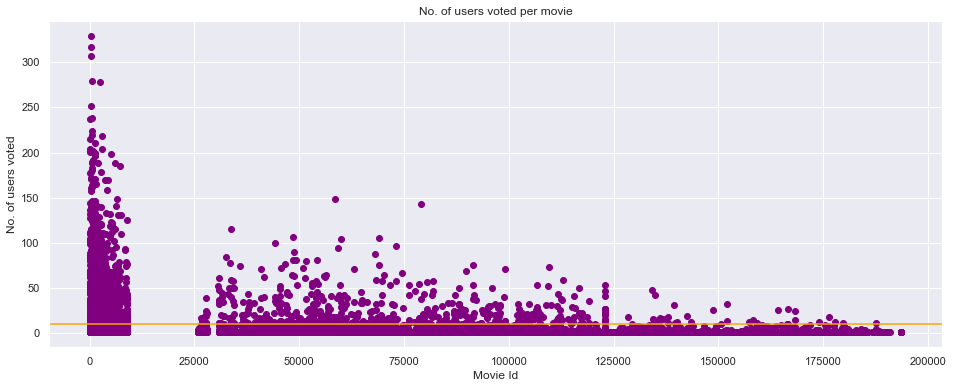

In [8]:
# Plot the number of users voted per each movie
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

plt.scatter(no_user_voted.index, 
            no_user_voted,
            color = 'purple')
plt.axhline(y = 10, 
            color = 'orange')

plt.title('No. of users voted per movie')
plt.xlabel('Movie Id')
plt.ylabel('No. of users voted')
plt.show()

In [9]:
# Final dataset 
# Remove all movies (rows) which have number of votes less than or equal 10
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

print(final_dataset.shape)
final_dataset.head()

(2121, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


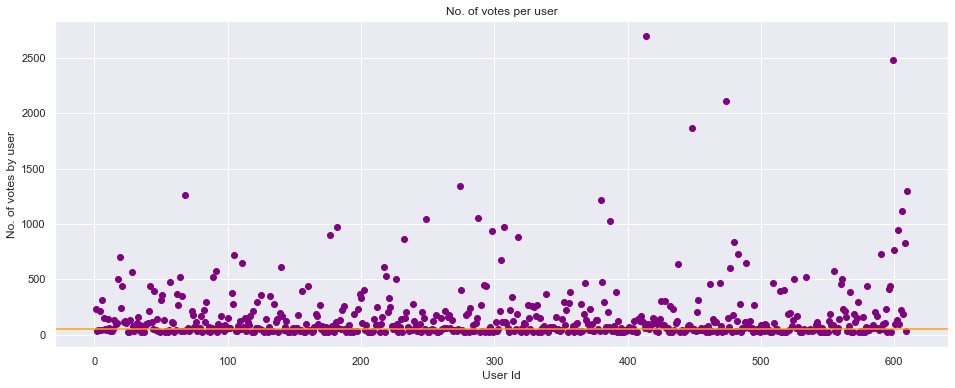

In [10]:
# Plot the number of votes per each user
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

plt.scatter(no_movies_voted.index,
            no_movies_voted,
            color = 'purple')
plt.axhline(y = 50, 
            color = 'orange')

plt.title('No. of votes per user')
plt.xlabel('User Id')
plt.ylabel('No. of votes by user')
plt.show()

In [11]:
# Final dataset
# Remove all Users (columns) which have no. of votes less than or equal 50
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]

print(final_dataset.shape)
final_dataset.head()

(2121, 378)


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [12]:
# Using csr_matrix to reduce sparsity
csr_data = csr_matrix(final_dataset.values)

# Reset the index for the final dataset
final_dataset.reset_index(inplace=True)
final_dataset.head()

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [13]:
# Train the model
knn = NearestNeighbors(metric = 'cosine', 
                       algorithm = 'brute',   # brute-force search.
                       n_neighbors = 20, 
                       n_jobs = -1)      # -1 --> using all processors
# Fit the model 
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [14]:
def get_movie_recommendation(movie_name):
    """ function used to get five recommended movies 
    Args:
    ----
          movie_name (String): String which is a name of movie               
   Returns:
   -------  
          return DataFrame consist of the top 5 movies and their Distances 
          based on a given movie title 
          or a str
    """
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]
    
    if len(movie_list):        
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]

        # Find the K-neighbors of a point
        distances, indices = knn.kneighbors(csr_data[movie_idx], 
                                            n_neighbors = n_movies_to_reccomend + 1) 
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), 
                                            distances.squeeze().tolist())),
                                            key = lambda x: x[1])[:0:-1]
        # print(rec_movie_indices)
        
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title': movies.iloc[idx]['title'].values[0], 
                                    'Distance': val[1]})
        # print(recommend_frame)
        
        # Dataframe of top five movies
        df = pd.DataFrame(recommend_frame, 
                          index = range(1, n_movies_to_reccomend + 1))
        return df
    else:
        return "No movies found. Please check your input"

In [15]:
# Calling the function to recommend the top 5 movies
# based on the given movie 'Iron Man'
get_movie_recommendation('Iron Man')

,Title,Distance
1,Avatar (2009),0.310893
2,Iron Man 2 (2010),0.307492
3,WALL·E (2008),0.298138
4,"Dark Knight, The (2008)",0.285835
5,"Avengers, The (2012)",0.285319


---

<center><h1><B>Second Recommender System</B></h1></center>

---

We will use the same MovieLens dataset for implementing the model recommender system. For implementing SVD for matrix factorization we would use the Surprise package.

In [16]:
np.random.seed(0)
reader = Reader()
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Next, we’ll transform the dataset to be read in an appropriate format by SVD. We’ll use RMSE as the measure to evaluate SVD’s performance.

In [17]:
# Transform dataset for appropriate format can be read by SVD
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()

# Use RMSE to evaluate SVD’s performance
cross_validate(svd, 
               data, 
               measures=['RMSE', 'MAE'], 
               cv=5)


{'test_rmse': array([0.88242841, 0.87754629, 0.86886655, 0.87332515, 0.86917316]),
 'test_mae': array([0.67692395, 0.676067  , 0.66900832, 0.66884863, 0.66746297]),
 'fit_time': (3.6648459434509277,
  3.7091598510742188,
  3.691528081893921,
  3.7293221950531006,
  3.7646169662475586),
 'test_time': (0.0833277702331543,
  0.11845803260803223,
  0.0813448429107666,
  0.08141493797302246,
  0.12046122550964355)}

In [18]:
# Built from the whole dataset
trainset = data.build_full_trainset()

# matrix factorization
svd.fit(trainset)

We have used cross-validation to train our recommender model using 5 folds- which basically means the whole dataset is iterated over 5 times- each time 4 parts of the dataset are used for training the model and one part for evaluating the recommender system.

The mean absolute error and RMSE is given for each iteration or fold. Let’s now choose a user of our choice, userId 1, and view all the movies this user has rated.

In [19]:
# Rated movies for a random user --> userID = 1
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


The next step is to predict the rating this user would give to a movie that he/she has not rated before.

In [20]:
def predict(userId, movieId):
    """
        fuction to predict the rating of a movie that a user didn't rate before
    Args:
    ----
          userId (int)  : the user ID
          movieId (int) : The movie ID 
   Returns:
   -------  
          return float predicted raring 
    """
    rating = svd.predict(userId, movieId) 
    return round(rating.est, 2)


In [21]:
# Predict the rating
print(predict(1, 2))

4.38


The system predicts that the user will rate the movieId 2 with 4.38, which is in a sense within the limits in which this user rates similar movies. So, model-based collaborative methods try to accurately predict a user’s preference (or rating) for a movie and then recommend movies that a user would like based on the predicted ratings.